# Based on
https://github.com/Fernerkundung/notebooks/blob/master/1D_interpolation.ipynb

In [18]:
# import necessary libraries
import numpy as np
import pandas as pd
from numba import jit
import matplotlib.pyplot as plt
import bottleneck as bn
%matplotlib inline

In [19]:
# create example data, original is (644, 4800, 4800)
test_arr =  np.random.uniform(low=-1.0, high=1.0, size=(92, 480, 480)).astype(np.float32)
test_arr[1:90:7, :, :] = np.nan  # NaN fill value in original data
test_arr[2,:,:] = np.nan
test_arr[:, 1:479:6, 1:479:8] = np.nan

In [20]:
def interpolate_nan(arr, method="linear", limit=3):
    """return array interpolated along time-axis to fill missing values"""
    result = np.zeros_like(arr, dtype=np.float32)

    for i in range(arr.shape[1]):
        # slice along y axis, interpolate with pandas wrapper to interp1d
        line_stack = pd.DataFrame(data=arr[:,i,:], dtype=np.float32)
        line_stack.interpolate(method=method, axis=0, inplace=True, limit=limit)
        result[:, i, :] = line_stack.values.astype(np.float32)
    return result

In [21]:
def interpolate_bottleneck(arr, inplace=True, window=3, min_count=1, axis=0):
    means = bn.move_mean(arr, window, min_count, axis)
    nans = np.isnan(arr)
    if inplace:
        result = arr
    else:
        result = np.copy(arr)
    result[nans] = means[nans]
    return result

In [22]:
@jit(nopython=True)
def interpolate_numba(arr):
    """return array interpolated along time-axis to fill missing values"""
    result = np.zeros_like(arr, dtype=np.float32)

    for x in range(arr.shape[2]):
        # slice along x axis
        for y in range(arr.shape[1]):
            # slice along y axis
            for z in range(arr.shape[0]):
                value = arr[z,y,x]
                if z == 0:  # don't interpolate first value
                    new_value = value
                elif z == len(arr[:,0,0])-1:  # don't interpolate last value
                    new_value = value

                elif np.isnan(value):  # interpolate

                    left = arr[z-1,y,x]
                    right = arr[z+1,y,x]
                    # look for valid neighbours
                    if not np.isnan(left) and not  np.isnan(right):  # left and right are valid
                        new_value = (left + right) / 2

                    elif np.isnan(left) and z == 1:  # boundary condition left
                        new_value = value
                    elif np.isnan(right) and z == len(arr[:,0,0])-2:  # boundary condition right
                        new_value = value

                    elif np.isnan(left) and not np.isnan(right):  # take second neighbour to the left
                        more_left = arr[z-2,y,x]
                        if np.isnan(more_left):
                            new_value = value
                        else:
                            new_value = (more_left + right) / 2

                    elif not np.isnan(left) and np.isnan(right):  # take second neighbour to the right
                        more_right = arr[z+2,y,x]
                        if np.isnan(more_right):
                            new_value = value
                        else:
                            new_value = (more_right + left) / 2

                    elif np.isnan(left) and np.isnan(right):  # take second neighbour on both sides
                        more_left = arr[z-2,y,x]
                        more_right = arr[z+2,y,x]
                        if not np.isnan(more_left) and not np.isnan(more_right):
                            new_value = (more_left + more_right) / 2
                        else:
                            new_value = value
                    else:
                        new_value = value
                else:
                    new_value = value
                result[z,y,x] = int(new_value)
    return result

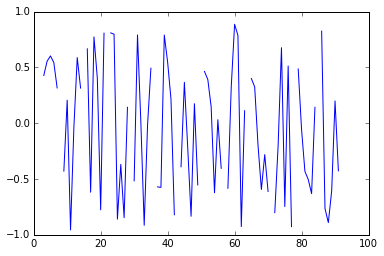

In [23]:
# show the example time-series at location (:,3,4)
plt.plot(test_arr[:,3,4])

In [24]:
result = interpolate_bottleneck(test_arr, False)

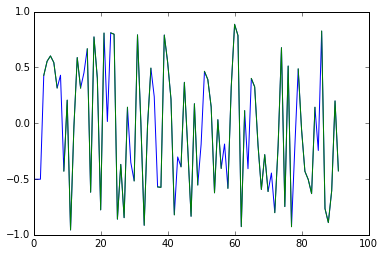

In [25]:
plt.plot(result[:,3,4])
plt.plot(test_arr[:,3,4])

# Some timings

In [26]:
#Straight bottleneck calculation of the windowed means, no filling of nans in input array
%timeit bottleneck.move_mean(test_arr, window=3, min_count=1, axis=0)

1 loops, best of 3: 294 ms per loop


In [27]:
#filling of nans in copy of array
%timeit interpolate_bottleneck(test_arr, inplace=False)

1 loops, best of 3: 397 ms per loop


In [28]:
#filling of nans in array in place
test_copy = np.copy(test_arr)
%timeit interpolate_bottleneck(test_copy)

1 loops, best of 3: 341 ms per loop


In [29]:
#NUMBA 1D interpolation
%timeit interpolate_numba(test_arr)

1 loops, best of 3: 927 ms per loop


In [13]:
#Original 1D interpolation
%timeit interpolate_nan(test_arr)


1 loops, best of 3: 51.2 s per loop
